In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [5]:
df.var()

account_length                   1575.963008
number_vmail_messages             180.630433
total_day_minutes                2917.336473
total_day_calls                   394.054948
total_day_charge                   84.310888
total_eve_minutes                2525.014078
total_eve_calls                   396.352000
total_eve_charge                   18.243252
total_night_minutes              2535.479804
total_night_calls                 403.737482
total_night_charge                  5.134402
total_intl_minutes                  7.618162
total_intl_calls                    6.066709
total_intl_charge                   0.555329
number_customer_service_calls       1.719858
dtype: float64

Looks like 4 columns have high variance and would possibly benefit some kind of normalization

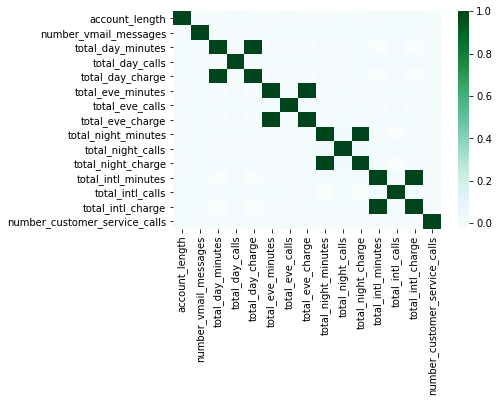

In [6]:
sns.heatmap(df.corr(),cmap='BuGn');

Looks like there is multicollinearity among certain numerical features, hence some will be dropped

In [7]:
df = df.copy()
df.drop(['total_day_charge','total_eve_charge','total_night_charge','total_intl_charge'],axis=1,inplace=True)

In [8]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,195.5,103,254.4,103,13.7,3,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,121.2,110,162.6,104,12.2,5,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,61.9,88,196.9,89,6.6,7,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,148.3,122,186.9,121,10.1,3,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,348.5,108,212.6,118,7.5,7,3,no


In [9]:
df.shape

(4250, 16)

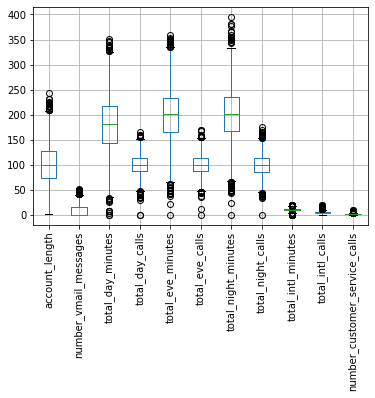

In [10]:
df[df.select_dtypes(['int64','float64']).columns].boxplot()
plt.xticks(rotation=90);

The boxplot overview suggests that, since some outliers are in, the options are either proceed with the removal or adopt a robust scaling. Let's try out removal

In [11]:
cols= list(df.select_dtypes(['int64','float64']).columns)

upper_limit = df[cols].quantile(0.75) + 1.5*(df[cols].quantile(0.75)-df[cols].quantile(0.25))
lower_limit = df[cols].quantile(0.25) - 1.5*(df[cols].quantile(0.75)-df[cols].quantile(0.25))
cleaned_df = df[~((df[cols]>upper_limit)|(df[cols]<lower_limit)).any(axis=1)]
cleaned_df.shape

(3516, 16)

In [12]:
print('Percentage of removed data: {:.2f}'.format(100-cleaned_df.shape[0]/df.shape[0]*100))

Percentage of removed data: 17.27


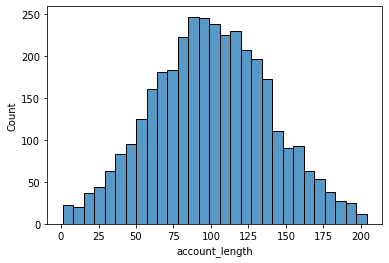

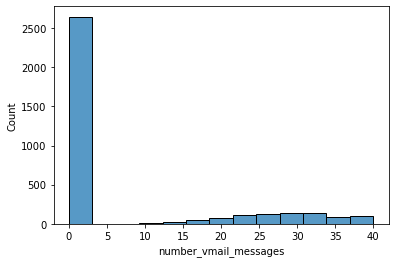

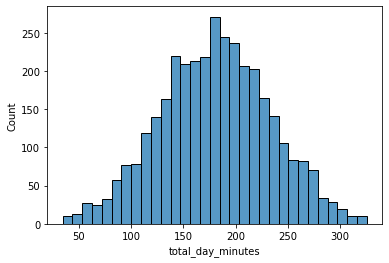

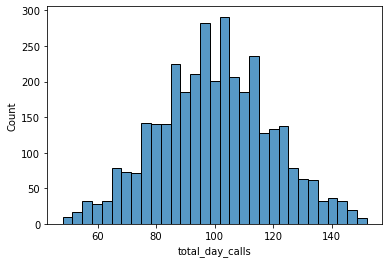

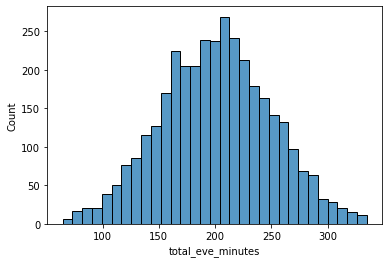

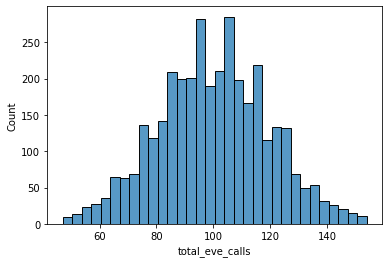

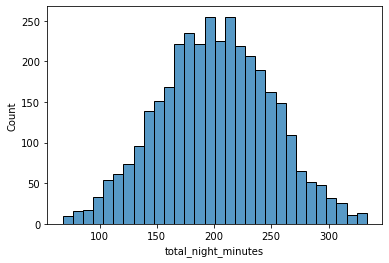

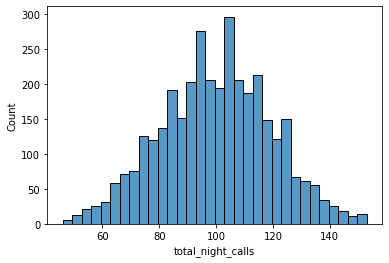

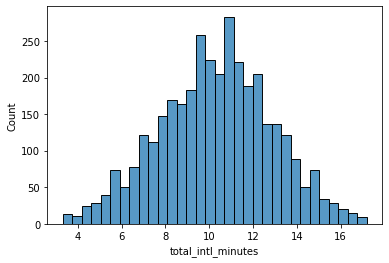

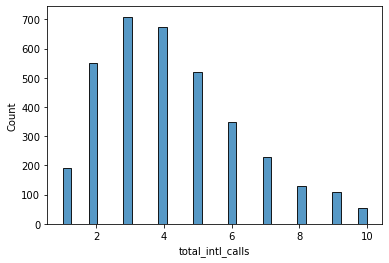

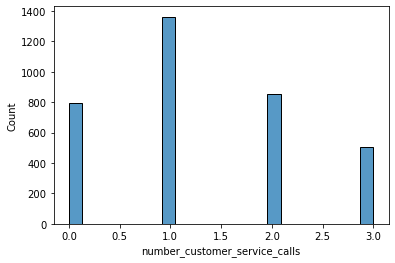

In [13]:
for i in cleaned_df.select_dtypes(['int64','float64']).columns:
    sns.histplot(cleaned_df[i]);
    plt.show();

The majority of numerical features shows a gaussian distribution, hence StandardScaler could be used too. Let's try MinMaxScaler

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = cleaned_df.copy()
df_scaled[df_scaled.select_dtypes(['int64','float64']).columns] = scaler.fit_transform(df_scaled[df_scaled.select_dtypes(['int64','float64']).columns])

Let's format bynary categorical features and target column as needed

In [15]:
df_scaled['international_plan'] = df_scaled.international_plan.apply(lambda x: 1 if x == 'yes' else 0)
df_scaled['voice_mail_plan'] = df_scaled.voice_mail_plan.apply(lambda x: 1 if x == 'yes' else 0)
df_scaled['churn'] = df_scaled.churn.apply(lambda x: 1 if x == 'yes' else 0)

In [16]:
df_scaled = pd.get_dummies(df_scaled)

In [17]:
df_scaled.churn.value_counts(normalize=True)

0    0.895051
1    0.104949
Name: churn, dtype: float64

The target column shows that the dataset is unbalanced, hence stratifying based on this column would be a good choice

### KNearestNeighbors

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score, balanced_accuracy_score, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

In [19]:
X = df_scaled.drop('churn',axis=1).values
y = df_scaled.churn.values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)

In [21]:
params = {'n_neighbors':[i for i in range(1,11)]}
knc = KNeighborsClassifier()
for i in ['f1','balanced_accuracy','accuracy','roc_auc']:
    rcv = RandomizedSearchCV(knc, param_distributions = params, cv=3,scoring = i,random_state=123)
    rcv.fit(X_train,y_train)
    print('Metrics: {}\nBest params: {}\nBest score: {}'.format(i,rcv.best_params_,rcv.best_score_))
    

Metrics: f1
Best params: {'n_neighbors': 1}
Best score: 0.17486337928498266
Metrics: balanced_accuracy
Best params: {'n_neighbors': 1}
Best score: 0.5416736179549052
Metrics: accuracy
Best params: {'n_neighbors': 9}
Best score: 0.8954488117424768
Metrics: roc_auc
Best params: {'n_neighbors': 10}
Best score: 0.6645843514564781


In [22]:
knc_f1 = []
knc_b_acc = []
knc_acc = []
knc_auc = []

for i in ['f1','balanced_accuracy','accuracy','roc_auc']:
    knc = KNeighborsClassifier(n_neighbors=10)
    metrics = cross_val_score(knc, X_train, y_train, cv = 10, scoring=i)
    if i == 'f1':
        knc_f1.append(metrics)
    elif i == 'balanced_accuracy':
        knc_b_acc.append(metrics)
    elif i == 'roc_auc':
        knc_auc.append(metrics)
    else:
        knc_acc.append(metrics)

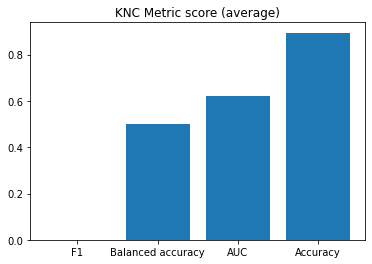

In [23]:
plt.bar(['F1','Balanced accuracy','AUC','Accuracy'],[np.mean(knc_f1), np.mean(knc_b_acc), np.mean(knc_auc),np.mean(knc_acc)])
plt.title('KNC Metric score (average)');

In [24]:
knc_train_acc = []
knc_test_acc = []

for k in range (1,21):
    knc = KNeighborsClassifier(n_neighbors=k)
    knc.fit(X_train,y_train)
    train_preds = knc.predict(X_train)
    test_preds = knc.predict(X_test)
    train_acc = accuracy_score(y_train,train_preds)
    test_acc = accuracy_score(y_test,test_preds)
    knc_train_acc.append(train_acc)
    knc_test_acc.append(test_acc)

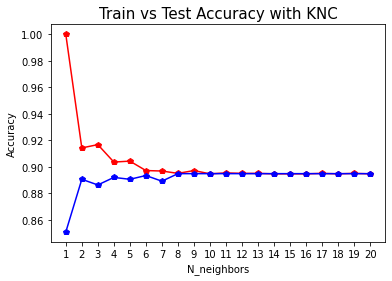

In [25]:
plt.plot(range(1,21),knc_train_acc, '-rp')
plt.plot(range(1,21),knc_test_acc, '-bp')
plt.xlabel('N_neighbors')
plt.ylabel('Accuracy')
plt.xticks(range(1,21))
plt.title('Train vs Test Accuracy with KNC',{'fontsize':15});

With K = 8 train accuracy and test accuracy are very close so the model does not seem to overfit

In [26]:
knc = KNeighborsClassifier(n_neighbors=8)
knc.fit(X_train,y_train)
preds_k_8 = knc.predict(X_test)
preds_prob_k_8 = knc.predict_proba(X_test)[:,1]
fpr_k_8, tpr_k_8, tresholds_k_8 = roc_curve(y_test,preds_prob_k_8)
prec_k_8, recall_k_8, tresh_k_8 = precision_recall_curve(y_test,preds_prob_k_8)
auc_score_k_8 = roc_auc_score(y_test,preds_prob_k_8)

### DecisionTreeClassifier

In [27]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

In [28]:
params = {'min_samples_split':[2,3,4],
          'min_samples_leaf':[1,2,3,4,5],
          'max_depth':[1,4,5,6,7]}

for i in ['f1','balanced_accuracy','accuracy','roc_auc']:
    rcv = RandomizedSearchCV(dt, param_distributions = params, cv=3,scoring = i,random_state=123)
    rcv.fit(X_train,y_train)
    print('Metrics: {}\nBest params: {}\nBest score: {}'.format(i,rcv.best_params_,rcv.best_score_))

Metrics: f1
Best params: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 7}
Best score: 0.7361434125923277
Metrics: balanced_accuracy
Best params: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4}
Best score: 0.817571108095542
Metrics: accuracy
Best params: {'min_samples_split': 3, 'min_samples_leaf': 5, 'max_depth': 7}
Best score: 0.9519933493077378
Metrics: roc_auc
Best params: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 5}
Best score: 0.8585895850496565


In [29]:
f1_dt = []
b_acc_dt = []
acc_dt = []
auc_dt = []

for i in ['f1','balanced_accuracy','accuracy','roc_auc']:
    dt = DecisionTreeClassifier(min_samples_split= 3, min_samples_leaf= 5, max_depth = 7)
    metrics = cross_val_score(dt, X_train, y_train, cv = 10, scoring=i)
    if i == 'f1':
        f1_dt.append(metrics)
    elif i == 'balanced_accuracy':
        b_acc_dt.append(metrics)
    elif i == 'roc_auc':
        auc_dt.append(metrics)
    else:
        acc_dt.append(metrics)

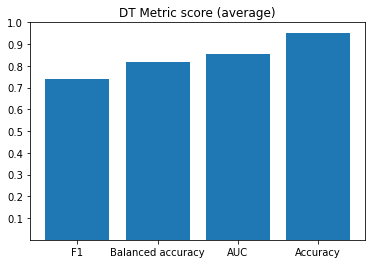

In [30]:
plt.bar(['F1','Balanced accuracy','AUC','Accuracy'],[np.mean(f1_dt), np.mean(b_acc_dt),np.mean(auc_dt),np.mean(acc_dt)])
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.title('DT Metric score (average)');

In [31]:
dt = DecisionTreeClassifier(min_samples_split= 3, min_samples_leaf= 5, max_depth = 7)
dt.fit(X_train,y_train)
preds_dt = dt.predict(X_test)
preds_prob_dt = dt.predict_proba(X_test)[:,1]
fpr_dt, tpr_dt, tresholds_dt = roc_curve(y_test,preds_prob_dt)
prec_dt, recall_dt, tresh_dt = precision_recall_curve(y_test,preds_prob_dt)
auc_score_dt = roc_auc_score(y_test,preds_prob_dt)

### LogisticRegression

In [32]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [33]:
params = {'C':[0.1,1,10,15,20,30,100,150,200], 'max_iter':[400,500,600]}

for i in ['f1','balanced_accuracy','accuracy','roc_auc']:
    rcv = RandomizedSearchCV(lr, param_distributions = params, cv=3,scoring = i,random_state=123)
    rcv.fit(X_train,y_train)
    print('Metrics: {}\nBest params: {}\nBest score: {}'.format(i,rcv.best_params_,rcv.best_score_))

Metrics: f1
Best params: {'max_iter': 600, 'C': 150}
Best score: 0.5167947844924513
Metrics: balanced_accuracy
Best params: {'max_iter': 600, 'C': 150}
Best score: 0.6947310545556756
Metrics: accuracy
Best params: {'max_iter': 600, 'C': 150}
Best score: 0.919631526769264
Metrics: roc_auc
Best params: {'max_iter': 600, 'C': 1}
Best score: 0.8627687118237093


In [34]:
f1_lr = []
b_acc_lr = []
acc_lr = []
auc_lr = []

for i in ['f1','balanced_accuracy','accuracy','roc_auc']:
    lr = LogisticRegression(C = 150, max_iter=600)
    metrics = cross_val_score(lr, X_train, y_train, cv = 4, scoring=i)
    if i == 'f1':
        f1_lr.append(metrics)
    elif i == 'balanced_accuracy':
        b_acc_lr.append(metrics)
    elif i == 'roc_auc':
        auc_lr.append(metrics)
    else:
        acc_lr.append(metrics)

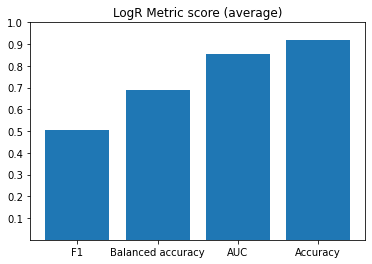

In [35]:
plt.bar(['F1','Balanced accuracy','AUC','Accuracy'],[np.mean(f1_lr), np.mean(b_acc_lr),np.mean(auc_lr), np.mean(acc_lr)])
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.title('LogR Metric score (average)');

In [36]:
lr = LogisticRegression(C = 150, max_iter=600)
lr.fit(X_train,y_train)
preds_lr = lr.predict(X_test)
preds_prob_lr = lr.predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, tresholds_lr = roc_curve(y_test,preds_prob_lr)
prec_lr, recall_lr, tresh_lr = precision_recall_curve(y_test,preds_prob_lr)
auc_score_lr = roc_auc_score(y_test,preds_prob_lr)

## RandomForest

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [38]:
params = {'n_estimators' : [300,400,500],
          'max_depth': [15,20,30],
          'min_samples_leaf':[2,3]}

for i in ['f1','balanced_accuracy','accuracy','roc_auc']:
    rcv = RandomizedSearchCV(rf, param_distributions = params, cv=3,scoring = i,random_state=123)
    rcv.fit(X_train,y_train)
    print('Metrics: {}\nBest params: {}\nBest score: {}'.format(i,rcv.best_params_,rcv.best_score_))

Metrics: f1
Best params: {'n_estimators': 300, 'min_samples_leaf': 2, 'max_depth': 15}
Best score: 0.5452829241512489
Metrics: balanced_accuracy
Best params: {'n_estimators': 500, 'min_samples_leaf': 2, 'max_depth': 30}
Best score: 0.6777887073732468
Metrics: accuracy
Best params: {'n_estimators': 400, 'min_samples_leaf': 2, 'max_depth': 20}
Best score: 0.9349217474147785
Metrics: roc_auc
Best params: {'n_estimators': 500, 'min_samples_leaf': 2, 'max_depth': 20}
Best score: 0.8825520576755039


In [39]:
f1_rf = []
b_acc_rf = []
acc_rf = []
auc_rf = []

for i in ['f1','balanced_accuracy','accuracy','roc_auc']:
    rf = RandomForestClassifier(n_estimators = 400, min_samples_leaf = 2, max_depth = 20)
    metrics = cross_val_score(rf, X_train, y_train, cv = 10, scoring=i)
    if i == 'f1':
        f1_rf.append(metrics)
    elif i == 'balanced_accuracy':
        b_acc_rf.append(metrics)
    elif i == 'roc_auc':
        auc_rf.append(metrics)
    else:
        acc_rf.append(metrics)

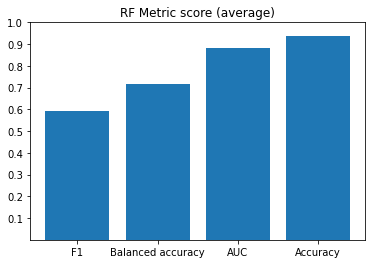

In [40]:
plt.bar(['F1','Balanced accuracy','AUC','Accuracy'],[np.mean(f1_rf), np.mean(b_acc_rf), np.mean(auc_rf),np.mean(acc_rf)])
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.title('RF Metric score (average)');

In [41]:
rf = RandomForestClassifier(n_estimators = 400, min_samples_leaf = 2, max_depth = 20)
rf.fit(X_train,y_train)
preds_rf = rf.predict(X_test)
preds_prob_rf = rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, tresholds_rf = roc_curve(y_test,preds_prob_rf)
prec_rf, recall_rf, tresh_rf = precision_recall_curve(y_test,preds_prob_rf)
auc_score_rf = roc_auc_score(y_test,preds_prob_rf)

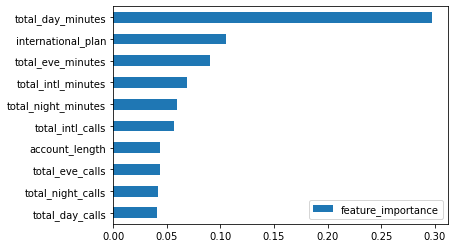

In [42]:
fi_df = pd.DataFrame(rf.feature_importances_, index = df_scaled.drop('churn',axis=1).columns, columns = ['feature_importance'])
fi_df[fi_df.feature_importance>0.03].sort_values('feature_importance').plot(kind='barh');

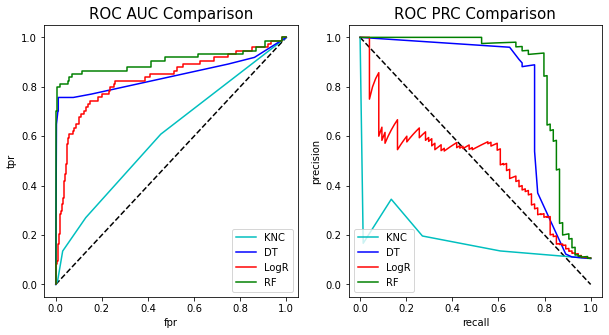

In [43]:
fig, [ax1,ax2] = plt.subplots(1,2)
fig.set_size_inches(10,5)

ax1.plot([0,1],'k--')
ax1.plot(fpr_k_8,tpr_k_8,'c',label = 'KNC')
ax1.plot(fpr_dt,tpr_dt,'b', label = 'DT')
ax1.plot(fpr_lr,tpr_lr,'r', label = 'LogR')
ax1.plot(fpr_rf,tpr_rf,'g', label = 'RF')
ax1.set_xlabel('fpr')
ax1.set_ylabel('tpr')
ax1.set_title('ROC AUC Comparison', {'fontsize':15})
ax1.legend()

ax2.plot([1,0],'k--')
ax2.plot(recall_k_8,prec_k_8,'c',label = 'KNC')
ax2.plot(recall_dt,prec_dt,'b', label = 'DT')
ax2.plot(recall_lr,prec_lr,'r', label = 'LogR')
ax2.plot(recall_rf,prec_rf,'g', label = 'RF')
ax2.set_xlabel('recall')
ax2.set_ylabel('precision')
ax2.set_title('ROC PRC Comparison', {'fontsize':15})
ax2.legend();

Since what matters most for a company is detecting clients who churn, we want to catch the ability to detect TPs while minimizing FNs. In this cases, similarly to medical issues, a FN is worse than a FP and that is why F1 score and ROC PRC would be good indicators. Although none of the models performed very high, the choice would be between Random Forest and Decision Tree algorithms

Now loading the official kaggle test set and perform the same feature selection/engeeneering done in the train set

In [44]:
test_off = pd.read_csv('test.csv')
test_off.head()

,id,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
0,1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,2,AL,118,area_code_510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0
2,3,IA,62,area_code_415,no,no,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4
3,4,VT,93,area_code_510,no,no,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3
4,5,NE,174,area_code_415,no,no,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3


In [45]:
test_off = test_off.copy()
test_off.drop(['total_day_charge','total_eve_charge','total_night_charge','total_intl_charge'],axis=1,inplace=True)

In [46]:
test_off_scaled = test_off.drop('id',axis=1).copy()
test_off_scaled[test_off_scaled.select_dtypes(['int64','float64']).columns] = scaler.fit_transform(test_off_scaled[test_off_scaled.select_dtypes(['int64','float64']).columns])

In [47]:
test_off_scaled['international_plan'] = test_off_scaled.international_plan.apply(lambda x: 1 if x == 'yes' else 0)
test_off_scaled['voice_mail_plan'] = test_off_scaled.voice_mail_plan.apply(lambda x: 1 if x == 'yes' else 0)

In [48]:
test_off_scaled = pd.get_dummies(test_off_scaled)

Now training the model on all the train set

In [49]:
rf = RandomForestClassifier(n_estimators = 400, min_samples_leaf = 2, max_depth = 20)
rf.fit(X,y)
predictions = rf.predict(test_off_scaled.values)
submit_df = pd.DataFrame(predictions,index=test_off.id, columns = ['Churn'])
submit_df['Churn'] = submit_df.Churn.astype('int64').apply(lambda x: 'yes' if x == 1 else 'no')
submit_df.to_csv('Submission for kaggle.csv')